# GHCNh false positive rate

In [1]:
# import libraries
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib.ticker import MaxNLocator
import sys
ghcnh_lib_path = "/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_eval_notebooks/GHCNh"
sys.path.append(ghcnh_lib_path)
from GHCNh_lib import GHCNh # If GHCNh is was appended to path
from qaqc_eval_utils import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
%%time
ghcnh = GHCNh(stations_local=True)
ghcnh.select_wecc()
id = ghcnh.stations_df['id'].iloc[0]
ghcnh.read_data_from_url(id, save=True)
ghcnh.convert_df_to_gpd()
lon = ghcnh.station_data.Longitude.mean()
lat = ghcnh.station_data.Latitude.mean()
print("{}, {:.5f}, {:.5f}".format(id, lon, lat))
ghcnh.station_data.head(3)

CAW00025343, -133.05000, 54.25000
CPU times: user 2.76 s, sys: 208 ms, total: 2.97 s
Wall time: 2.97 s


,Station_ID,Station_name,Year,Month,Day,Hour,Minute,Latitude,Longitude,Elevation,...,precipitation_24_hour_Source_Code,precipitation_24_hour_Source_Station_ID,remarks,remarks_Measurement_Code,remarks_Quality_Code,remarks_Report_Type,remarks_Source_Code,remarks_Source_Station_ID,time,geometry
0,CAW00025343,LANGARA,1954,1,1,9,0,54.25,-133.05,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-01-01 09:00:00,POINT (-14811058.250 7217646.198)
1,CAW00025343,LANGARA,1954,1,1,21,0,54.25,-133.05,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-01-01 21:00:00,POINT (-14811058.250 7217646.198)
2,CAW00025343,LANGARA,1954,1,2,3,0,54.25,-133.05,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-01-02 03:00:00,POINT (-14811058.250 7217646.198)


In [3]:
# read in stations
train_stns = pd.read_csv('../qaqc_training_station_list_events.csv')

In [4]:
# how to identify other events of interest using a start and end date
alt_start_date = "2007-10-20"
alt_end_date = "2007-10-24"
alt_event_stns = find_other_events (train_stns, event_start=alt_start_date, event_end=alt_end_date, buffer=14, subset=5)
alt_event_stns.head(3)

Subsetting station record for event duration with 14 day buffer...
5 stations selected for evaluation for comparison!
Stations selected for evaluation:
 ['CIMIS_199', 'HADS_YRSC2', 'HADS_MCDO3', 'ASOSAWOS_72467793007', 'ASOSAWOS_72492023237']


,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes
228,CIMIS,CIMIS_199,6910.0,34.237645,-116.86585,2005-07-19 00:00:00+00:00,2024-01-22 13:36:19.951554+00:00,"AR, mudslide, heatwave1, heatwave2, heatwave3,...",NaN
691,HADS,HADS_YRSC2,7880.0,40.153330,-106.91167,2000-01-17 00:00:00+00:00,2023-01-16 16:00:00+00:00,"AR, mudslide, heatwave1, heatwave2, heatwave3,...",NaN
645,HADS,HADS_MCDO3,4464.0,42.410560,-117.86278,2006-12-16 00:00:00+00:00,2023-01-16 16:45:00+00:00,"AR, mudslide, heatwave1, heatwave2, heatwave3,...",NaN


In [5]:
specific_station = 'CIMIS_45'
specific_station = 'CIMIS_75'

In [6]:
eval_stations = subset_eval_stns(
    event_to_eval = 'santa_ana_wind',
    stn_list = train_stns,
    # subset = 5,
    # subset = None,
    specific_station=specific_station,
    return_stn_ids = True
)
eval_stations.head(3)

17 potential stations available for evaluation for santa_ana_wind event.
Stations selected for evaluation:
 ['CIMIS_75']


,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes,STATEFP,...,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
16,CIMIS,CIMIS_75,410.0,33.68845,-117.72118,1987-10-07 00:00:00+00:00,2024-01-22 13:36:19.951554+00:00,all,NaN,06,...,31080,11244,A,2.053368e+09,401931862.0,+33.6756872,-117.7772068,261547.8529,3.554704e+09,POINT (-13104661.813 3987044.797)


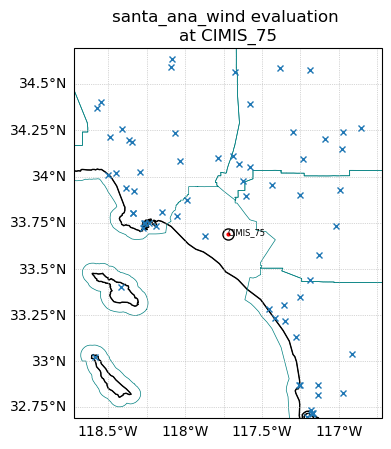

In [7]:
fig,ax = stn_visualize(
    stn_id = eval_stations['era-id'].values[-1],
    stn_list = eval_stations,
    event_to_eval = 'santa_ana_wind'
)

ax.plot(ghcnh.stations_df.longitude, ghcnh.stations_df.latitude, 'x', markersize=4, transform=ccrs.PlateCarree(), mfc='none')

In [8]:
eval_stations['era-id'].values[-1]
# eval_stations.loc[eval_stations['era-id']==stn_id]

'CIMIS_75'

In [9]:
stn_id = eval_stations['era-id'].values[-1]
point = eval_stations.loc[eval_stations['era-id']==stn_id].geometry.iloc[0]
ghcnh_stations_df = ghcnh.stations_df.copy()
display(eval_stations.loc[eval_stations['era-id']==stn_id, ["longitude","latitude"]])
ghcnh_stations_df['distance_to_eval'] = ghcnh_stations_df.distance(point, )
ghcnh_stations_df = ghcnh_stations_df.sort_values(by="distance_to_eval")
ghcnh_stations_df.head(5)

,longitude,latitude
16,-117.72118,33.68845


,id,latitude,longitude,elevation,state,name,gsn_flag,hcn,crn_flag,wmo_id,url,is_in_wecc,geometry,distance_to_eval
5627,USW00093184,33.6797,-117.8675,13.1,CA,SANTA ANA JOHN WAYNE AP,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-13120950.081 3985874.222),16330.276109
5138,USW00053175,33.8978,-117.6025,162.5,CA,CORONA MUNICIPAL AP,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-13091450.416 4015087.305),30998.762024
3575,USW00003166,33.8717,-117.9855,26.2,CA,FULLERTON MUNI AP,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-13134085.781 4011587.454),38315.948053
5110,USW00053141,33.7900,-118.0519,10.7,CA,LOS ALAMITOS AAF,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-13141477.395 4000638.892),39245.209887
3582,USW00003179,33.9756,-117.6250,193.9,CA,CHINO AP,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-13093955.105 4025526.173),39943.083072


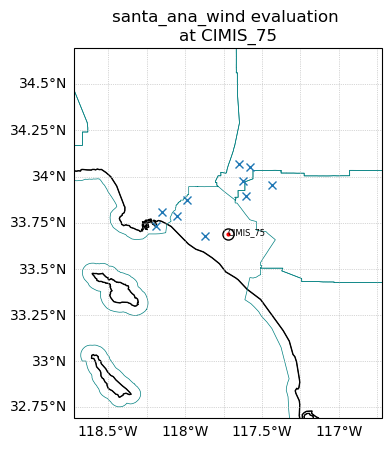

In [10]:
fig,ax = stn_visualize(
    stn_id = eval_stations['era-id'].values[-1],
    stn_list = eval_stations,
    event_to_eval = 'santa_ana_wind'
)

plot_df = ghcnh_stations_df.iloc[:10]
ax.plot(plot_df.longitude, plot_df.latitude, 'x', markersize=6, transform=ccrs.PlateCarree(), mfc='none');

In [11]:
def return_ghcn_vars(ghcn_df, input_var):
    '''
    Given an input variable, return GHCNh location variables and all relevant data variables,
    rather than utilizing the whole 240 cols, or having to know how ghcnh labels the cols.

    input_var must follow ERA naming scheme (tas, tdps, ps, pr, etc.)
    '''
    ghcnh_vars = pd.read_csv('ghcnh_data_headers.csv')

    # include station-ID, time, loc, elevation (cols 1-10)
    stn_info_cols = ['Station_ID', 'Station_name', 'time',
                     'Latitude','Longitude','Elevation',
                     'geometry'
                    ]
    vars = {
        'tas': 'temperature',
        'tdps': 'dew_point_temperature',
        'tdps_derived': 'dew_point_temperature',
        'ps': 'station_level_pressure',
        'psl': 'station_level_pressure',
        'sfcWind_dir': 'wind_direction',
        'sfcWind': 'wind_speed',
        'tas': 'temperature',
        'hurs': 'relative_humidity',
        'rsds': "N/A",
        'pr': 'precipitation',
        'pr_1h': 'precipitation',
        'pr_5min': 'precipitation',
    }
    if input_var in vars.keys():
        i = ghcn_df.columns.get_loc(vars[input_var])
        j = i+6
        # For wind, include wind gust
        if input_var=="sfcWind":
            j = j+6
        var_cols = ghcn_df.iloc[:, i:j].columns
        return_cols = np.concatenate([stn_info_cols,var_cols])
        
        return ghcn_df.loc[:, return_cols], vars
    else:
        raise Exception(f"Variable {input_var} not in variables' dictionary")

In [23]:
vars = {
    'tas': 'temperature',
    'tdps': 'dew_point_temperature',
    'tdps_derived': 'dew_point_temperature',
    'ps': 'station_level_pressure',
    'psl': 'station_level_pressure',
    'sfcWind_dir': 'wind_direction',
    'sfcWind': 'wind_speed',
    'tas': 'temperature',
    'hurs': 'relative_humidity',
    'rsds': "N/A",
    'pr': 'precipitation',
    'pr_1h': 'precipitation',
    'pr_5min': 'precipitation',
}

In [12]:
stn_id

'CIMIS_75'

In [13]:
# df, vars = return_ghcn_vars(ghcnh.station_data, 'tas')

In [14]:
# len(df.temperature_Quality_Code.dropna())/len(df.temperature_Quality_Code)

In [15]:
%%time
ds = pull_nc_from_aws(specific_station) # manually retrieve a specific station
ds

Retrieving data for station...
CPU times: user 2.96 s, sys: 1.41 s, total: 4.38 s
Wall time: 28.8 s


<xarray.Dataset>
Dimensions:               (station: 1, time: 305943)
Coordinates:
  * station               (station) object 'CIMIS_75'
  * time                  (time) datetime64[ns] 1987-10-07T09:00:00 ... 2022-...
Data variables: (12/30)
    tas                   (station, time) float64 ...
    pr                    (station, time) float64 ...
    hurs                  (station, time) float64 ...
    rsds                  (station, time) float64 ...
    sfcWind               (station, time) float64 ...
    sfcWind_dir           (station, time) float64 ...
    ...                    ...
    sfcWind_dir_eraqc     (station, time) float64 ...
    elevation_eraqc       (station, time) float64 ...
    tdps_derived_eraqc    (station, time) float64 ...
    pvp_derived_eraqc     (station, time) float64 ...
    anemometer_height_m   (station, time) float64 ...
    thermometer_height_m  (station, time) float64 ...
Attributes: (12/16)
    title:                 CIMIS quality controlled
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               CIMIS_clean.py script run on 02-13-2023, 22:25:54 ...
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    wind_vane_height_m:    2.0
    anemometer_height_m:   2.0
    thermometer_height_m:  1.5
    humidity_height_m:     1.5
    rain_gauge_height_m:   1.0
    raw_files_merged:      47

In [17]:
df, MultiIndex, attrs, var_attrs, era_qc_vars = qaqc_ds_to_df(ds)
df.head(3)

['tas_eraqc', 'pr_eraqc', 'hurs_eraqc', 'rsds_eraqc', 'sfcWind_eraqc', 'sfcWind_dir_eraqc', 'elevation_eraqc', 'tdps_derived_eraqc', 'pvp_derived_eraqc']
Filling anemometer_height_m with NaN.
Filling thermometer_height_m with NaN.


,time,tas,pr,hurs,rsds,sfcWind,sfcWind_dir,pr_qc,rsds_qc,pvp_derived_qc,...,tdps_derived_eraqc,pvp_derived_eraqc,anemometer_height_m,thermometer_height_m,station,hour,day,month,year,date
0,1987-10-07 09:00:00,290.75,0.0,9.0,0.0,0.8,87.1,nan,nan,nan,...,NaN,NaN,NaN,NaN,CIMIS_75,9,7,10,1987,1987-10-07
1,1987-10-07 10:00:00,290.85,0.0,7.0,-1.0,0.7,76.2,nan,nan,nan,...,NaN,NaN,NaN,NaN,CIMIS_75,10,7,10,1987,1987-10-07
2,1987-10-07 11:00:00,290.65,0.0,7.0,-1.0,1.0,11.7,nan,nan,nan,...,NaN,NaN,NaN,NaN,CIMIS_75,11,7,10,1987,1987-10-07


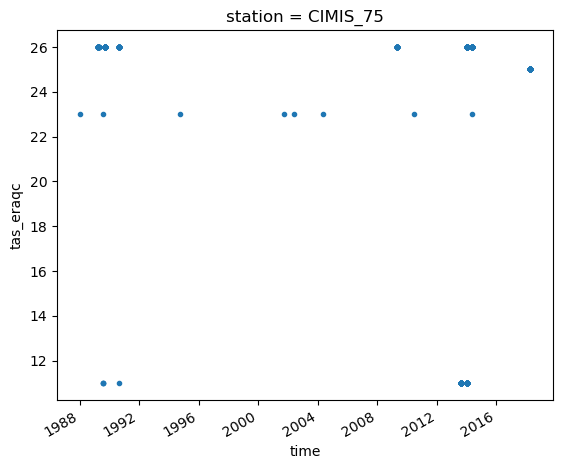

In [18]:
ds.tas_eraqc.plot(marker=".", lw=0)

<AxesSubplot:>

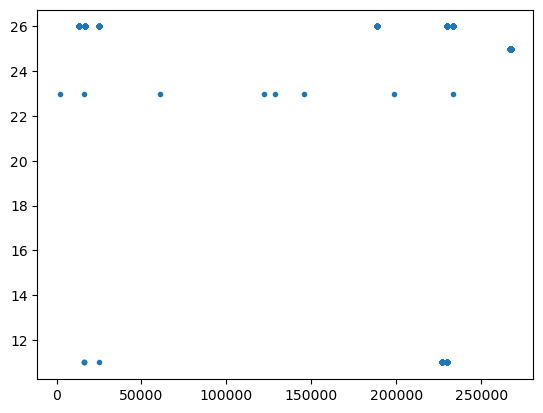

In [19]:
df.tas_eraqc.plot(marker=".", lw=0)

In [96]:
var = "hurs"
var = "tas"

print("\n{}".format(specific_station))
print(df.iloc[[0,-1]]['time'].values)
print(len(df[var+"_eraqc"].dropna())/len(df[var+"_eraqc"]))

for i in range(1):
    id = ghcnh_stations_df['id'].iloc[i]
    ghcnh.read_data_from_url(id, save=True)
    ghcnh.convert_df_to_gpd()
    tmp_df = ghcnh.station_data.copy()

    ghcnh_df, vars = return_ghcn_vars(tmp_df, var)
    print("=============================")
    print("{}".format(id))
    # print(ghcnh_df.iloc[[0,-1]].apply(lambda row: pd.Timestamp(row["Year"],row["Month"],row["Day"],row["Hour"]), axis=1).values)
    print(ghcnh_df.iloc[[0,-1]]['time'].values)
    print(len(ghcnh_df[vars[var]+'_Quality_Code'].dropna())/len(ghcnh_df[vars[var]+'_Quality_Code']))
    
    print()


CIMIS_75
['1987-10-07T09:00:00.000000000' '2022-08-31T23:00:00.000000000']
0.0016898572609930608
USW00093184
['1940-06-17T22:00:00.000000000' '2024-06-26T01:53:00.000000000']
0.9673853504922718



In [102]:
ghcnh_df[vars[var]+'_Quality_Code']

0           1
1           1
2           1
3           1
4           1
         ... 
494742    5.0
494743    5.0
494744    5.0
494745    5.0
494746    5.0
Name: temperature_Quality_Code, Length: 494747, dtype: object

<AxesSubplot:>

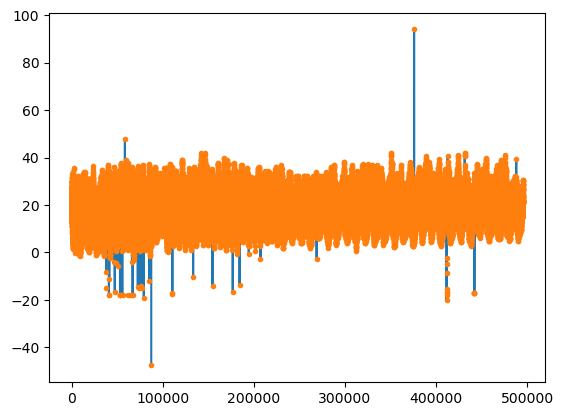

In [98]:
ghcnh_df[vars[var]].plot()
ghcnh_df.dropna(subset=vars[var]+"_Quality_Code")[vars[var]].plot(marker=".", lw=0)

<AxesSubplot:xlabel='time'>

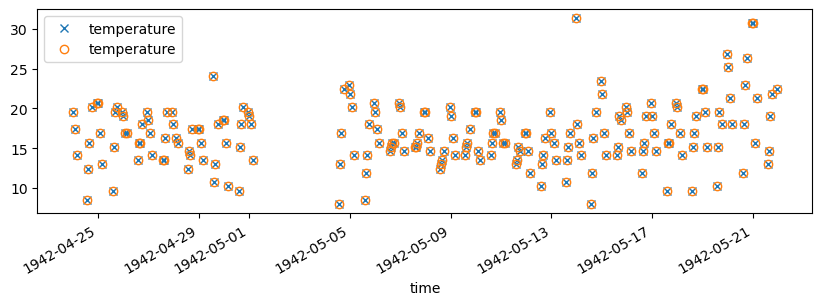

In [127]:
fig,ax = plt.subplots(figsize=(10,3))
pd.DataFrame(ghcnh_df).iloc[5000:5200].plot(x="time",y="temperature",marker="x", lw=0, ax=ax)
pd.DataFrame(ghcnh_df).iloc[5000:5200].dropna(subset=vars[var]+"_Quality_Code").plot(x="time",y="temperature",marker="o", mfc="none", lw=0, ax=ax)

In [137]:
len(ghcnh_df.dropna(subset=vars[var]+"_Quality_Code"))/len(ghcnh_df)

0.9673853504922718

In [87]:
print(len(ghcnh_df[vars[var]+'_Quality_Code'].dropna())/len(ghcnh_df[vars[var]+'_Quality_Code']))

0.8658175736523864


In [89]:
ghcnh_df[vars[var]+'_Quality_Code'].unique()

array(['U', nan, '1', 'dCN', 'dC', 'CN', 'dCNE', 'E', 'dNE', 'dE', 'NE',
       'N', 'dCE', '2', 1.0, 2.0, 'dN', 'SN', 'd', 4.0, '4', 'K', 5.0,
       6.0, '5', '6', 'S', 7.0, '7', 'dCSN'], dtype=object)

In [142]:
np.setdiff1d(ghcnh_df[vars[var]+'_Quality_Code'].dropna().index, ghcnh_df.index)

array([], dtype=int64)

In [179]:
ind = pd.isna(ghcnh_df[vars[var]+'_Quality_Code'])
len(np.where(ind)[0])
len(plot_df[ind])

16136

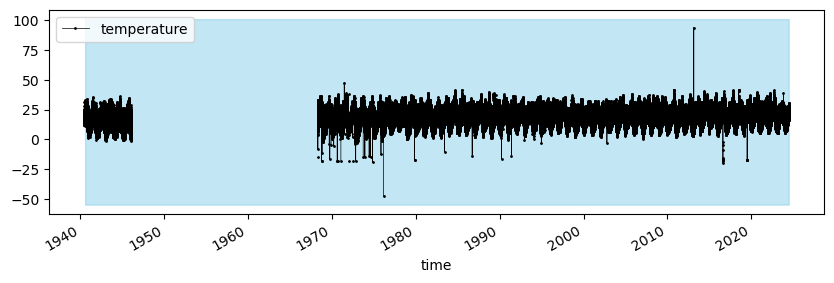

In [181]:
fig,ax = plt.subplots(figsize=(10,3))
plot_df = pd.DataFrame(ghcnh_df)
plot_df.plot(x="time", y=vars[var], 
            ax=ax, marker=".", lw=0.5, color="black",
            markersize=2)
ax.fill_between(x=plot_df[ind].time, y1=ax.get_ylim()[0], y2=ax.get_ylim()[1], color='skyblue', alpha=0.5)
# plot_df = plot_df[ind]
# plot_df.plot(x="time", y=vars[var], 
#              ax=ax, marker="o", lw=0.0, color="red",
#              markersize=4, label='Streaks', mfc='none')

<AxesSubplot:xlabel='time'>

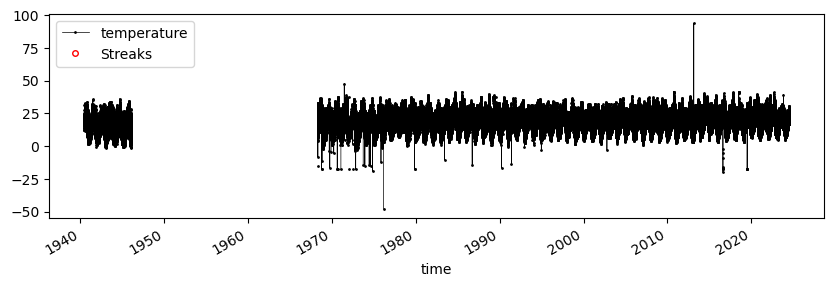

In [138]:
fig,ax = plt.subplots(figsize=(10,3))
plot_df = pd.DataFrame(ghcnh_df)
plot_df.plot(x="time", y=vars[var], 
                            ax=ax, marker=".", lw=0.5, color="black",
                            markersize=2)
plot_df = plot_df[plot_df[vars[var]+'_Quality_Code']=='K']
plot_df.plot(x="time", y=vars[var], 
             ax=ax, marker="o", lw=0.0, color="red",
             markersize=4, label='Streaks', mfc='none')

(12119.0, 12134.0)

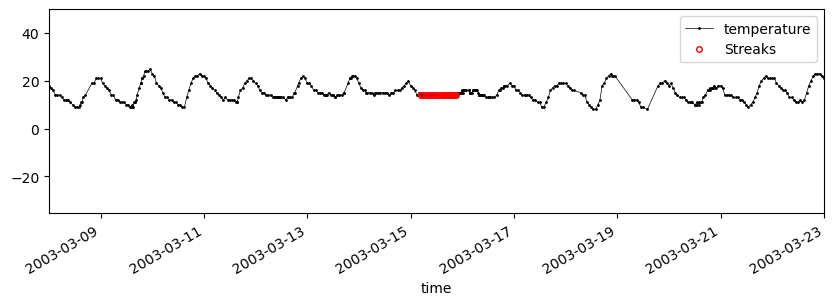

In [95]:
fig,ax = plt.subplots(figsize=(10,3))
plot_df = pd.DataFrame(ghcnh_df)
plot_df.plot(x="time", y=vars[var], 
                            ax=ax, marker=".", lw=0.5, color="black",
                            markersize=2)
plot_df = plot_df[plot_df[vars[var]+'_Quality_Code']=='K']
plot_df.plot(x="time", y=vars[var], 
             ax=ax, marker="o", lw=0.0, color="red",
             markersize=4, label='Streaks', mfc='none')
ax.set_xlim(np.datetime64("2003-03-08"),np.datetime64("2003-03-23"))

<AxesSubplot:xlabel='time'>

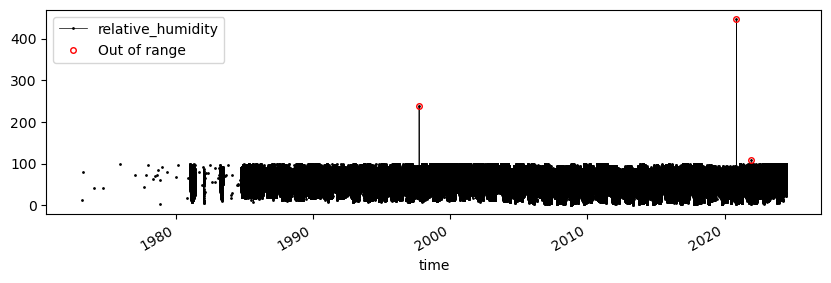

In [83]:
fig,ax = plt.subplots(figsize=(10,3))
plot_df = pd.DataFrame(ghcnh_df)
plot_df.plot(x="time", y=vars[var], 
                            ax=ax, marker=".", lw=0.5, color="black",
                            markersize=2)
plot_df = plot_df[plot_df[vars[var]+'_Quality_Code']=='o']
plot_df.plot(x="time", y=vars[var], 
             ax=ax, marker="o", lw=0.0, color="red",
             markersize=4, label='Out of range', mfc='none')

<AxesSubplot:xlabel='time'>

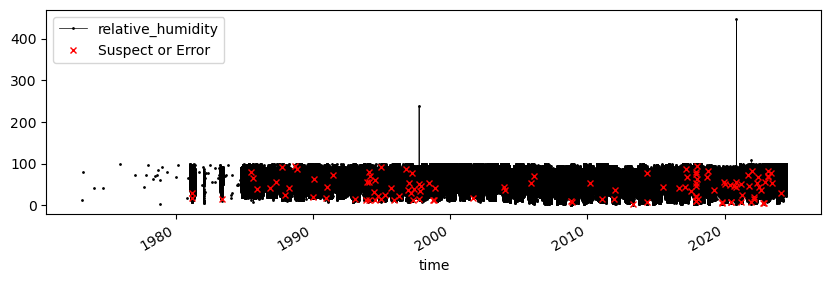

In [84]:
fig,ax = plt.subplots(figsize=(10,3))
plot_df = pd.DataFrame(ghcnh_df)
plot_df.plot(x="time", y=vars[var], 
                            ax=ax, marker=".", lw=0.5, color="black",
                            markersize=2)
plot_df = plot_df[plot_df[vars[var]+'_Quality_Code']=='f']
plot_df.plot(x="time", y=vars[var], 
             ax=ax, marker="x", lw=0.0, color="red",
             markersize=4, label='Suspect or Error', mfc='none')

In [70]:
ghcnh_df.columns

Index(['Station_ID', 'Station_name', 'time', 'Latitude', 'Longitude',
       'Elevation', 'geometry', 'relative_humidity',
       'relative_humidity_Measurement_Code', 'relative_humidity_Quality_Code',
       'relative_humidity_Report_Type', 'relative_humidity_Source_Code',
       'relative_humidity_Source_Station_ID'],
      dtype='object')

In [71]:
ghcnh_df['relative_humidity_Measurement_Code'].unique()

array([nan, 'Derived'], dtype=object)

In [72]:
ghcnh_df['relative_humidity_Quality_Code'].unique()

array([nan, 'f', 'o'], dtype=object)

In [73]:
ghcnh_df['relative_humidity_Report_Type'].unique()

array([nan, 'SAO-Airway', 'SAOSP-Airw', 'FM15-METAR', 'FM16-SPECI',
       'AUTO_4-USA'], dtype=object)

In [74]:
ghcnh_df['relative_humidity_Source_Code'].unique()

array([ nan, 223., 343.])

In [75]:
ghcnh_df['relative_humidity_Source_Station_ID'].unique()

array([nan, 'ICAO-KFUL', '999999-03166', '722976-03166'], dtype=object)

In [76]:
# df[var+"_eraqc"]

In [24]:
df.dropna(subset=vars["tas"])

,Station_ID,Station_name,time,Latitude,Longitude,Elevation,temperature,temperature_Measurement_Code,temperature_Quality_Code,temperature_Report_Type,temperature_Source_Code,temperature_Source_Station_ID
0,CAW00025343,LANGARA,1954-01-01 09:00:00,54.25,-133.05,41.1,3.9,NaN,U,SAO-Airway,335.0,999999-25343
1,CAW00025343,LANGARA,1954-01-01 21:00:00,54.25,-133.05,41.1,1.7,NaN,U,SAO-Airway,335.0,999999-25343
2,CAW00025343,LANGARA,1954-01-02 03:00:00,54.25,-133.05,41.1,3.3,NaN,4,SAO-Airway,335.0,999999-25343
3,CAW00025343,LANGARA,1954-01-02 09:00:00,54.25,-133.05,41.1,2.8,NaN,4,SAO-Airway,335.0,999999-25343
4,CAW00025343,LANGARA,1954-01-02 21:00:00,54.25,-133.05,41.1,1.1,NaN,4,SAO-Airway,335.0,999999-25343
...,...,...,...,...,...,...,...,...,...,...,...,...
87612,CAW00025343,LANGARA,1999-12-31 06:00:00,54.25,-133.05,41.1,2.5,NaN,1,SYMT-Synop,335.0,718990-25343
87613,CAW00025343,LANGARA,1999-12-31 12:00:00,54.25,-133.05,41.1,5.5,NaN,1,SYMT-Synop,335.0,718990-25343
87614,CAW00025343,LANGARA,1999-12-31 15:00:00,54.25,-133.05,41.1,5.7,NaN,1,SYMT-Synop,335.0,718990-25343
87615,CAW00025343,LANGARA,1999-12-31 18:00:00,54.25,-133.05,41.1,5.5,NaN,1,SYMT-Synop,335.0,718990-25343


In [8]:
len(df.temperature_Quality_Code.dropna())/len(df.temperature_Quality_Code)

0.9602136547284804

- ERA5 map
- Accumulated flags
- Interpolated stations or mean


In [19]:
ghcnh.convert_df_to_gpd(ghcnh.station_data)